<h2 align="center">CYFLOD: Cyclic Filtering and Loss Damping for Alleviating Noisy Labels in Fine-grained Visual Classification</h2>
<h3 align="center">Submission: 1008.</h3>
<h3 align="center">Aircraft-Asymmetric Noise 30%</h3>

In [1]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from fastai.vision.widgets import ImageClassifierCleaner
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
from fastai.vision.all import *
from fastai import __version__
import torchvision
import fastai
import pandas as pd
from pathlib import Path
import seaborn as sns
import random as rn
import torch
import random
import os.path
import math
import shutil
import os

In [2]:
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


In [3]:
noise_ratio = 0.3
loss_function = 'DampedCELoss' 
dataset = 'aircrafts'
noise_type = 'asym'
baseline = 'baseline'
scheme = 'scheme'
feat = 'baseline_features'
num_classes  = 100
damp_1 = 0.25
damp_2 = 0.50
best_pth = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+baseline
feature_path = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)+'_'+feat
damp_1_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_1_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_1)
damp_2_features =  loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)
damp_2_csvs = loss_function+"_"+dataset+"_"+noise_type+"_"+str(noise_ratio)+'_'+str(damp_2)

print(f'Best model: {best_pth}')
print(f'Model Features: {feature_path}')
print(f'Saving features from Scheme delta = 0.25: {damp_1_features}')
print(f'Csv save: {damp_1_csvs}')
print(f'Saving features from Scheme delta = 0.25: {damp_2_features}')
print(f'Saving csv for damp_2: {damp_2_csvs}')

Best model: DampedCELoss_aircrafts_asym_0.3_0.25_baseline
Model Features: DampedCELoss_aircrafts_asym_0.3_0.25_baseline_features
Saving features from Scheme delta = 0.25: DampedCELoss_aircrafts_asym_0.3_0.25
Csv save: DampedCELoss_aircrafts_asym_0.3_0.25
Saving features from Scheme delta = 0.25: DampedCELoss_aircrafts_asym_0.3_0.5
Saving csv for damp_2: DampedCELoss_aircrafts_asym_0.3_0.5


# Declaration of Efficient Net family with Resolution, and  Batch size

In [3]:
architecture = 'efficientnet-b4'
logfile = 'efficientnet-b0-MENA.csv'

## The tables
effnet_size = ({
    'efficientnet-b0':300,      # original resolution
    'efficientnet-b1':240,      # original resolution
    'efficientnet-b2':260,      # original resolution
    'efficientnet-b3':400,      # original resolution
    'efficientnet-b4':450,      # original resolution
    'efficientnet-b5':456,      # original resolution
    'efficientnet-b6':528,      # original resolution
    'efficientnet-b7':600,      # original resolution
    'efficientnet-lite0':224,
    'efficientnet-lite2':260,
    'efficientnet-lite4':384,
    'resnet18':224,
    'resnet34':224,
    'resnet50':224,
    'resnet101':224,
    'resnet152':224
})
batch_size = ({ 
    'efficientnet-b0':128, # bs = 256 for B1
    'efficientnet-b1':120,      #
    'efficientnet-b2':160,       #88 160
    'efficientnet-b3':16,       #
    'efficientnet-b4':16,       #
    'efficientnet-b5':14,       #
    'efficientnet-b6':16,
    'efficientnet-b7':8,
    'efficientnet-lite0': 160,
    'efficientnet-lite2': 160,
    'efficientnet-lite4':24,
    
    'resnet18':400,             # 3080: ok
    'resnet34':320,            # RTX 3090 rocz!
    'resnet50':256,             # 3080: ok
    'resnet101':96,
    'resnet152':64
})

 # Writing training data into csv

In [4]:
import pandas as pd
train_df = pd.read_csv(dataset+"_"+noise_type+"_"+str(noise_ratio)+".csv")
train_df

,Filepath,Noisy_labels,Label,Label_numeric
0,aircrafts_original/0/0716386.jpg,1,0,0
1,aircrafts_original/0/0810608.jpg,1,0,0
2,aircrafts_original/0/1427680.jpg,1,0,0
3,aircrafts_original/0/1017179.jpg,1,0,0
4,aircrafts_original/0/0536721.jpg,1,0,0
...,...,...,...,...
6662,aircrafts_original/99/1117057.jpg,99,99,99
6663,aircrafts_original/99/1026133.jpg,99,99,99
6664,aircrafts_original/99/0730106.jpg,99,99,99
6665,aircrafts_original/99/1801242.jpg,99,99,99


In [5]:
print(train_df.Noisy_labels.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

# Viualization of Training Data, Samples per class

Text(0, 0.5, 'Number of Images')

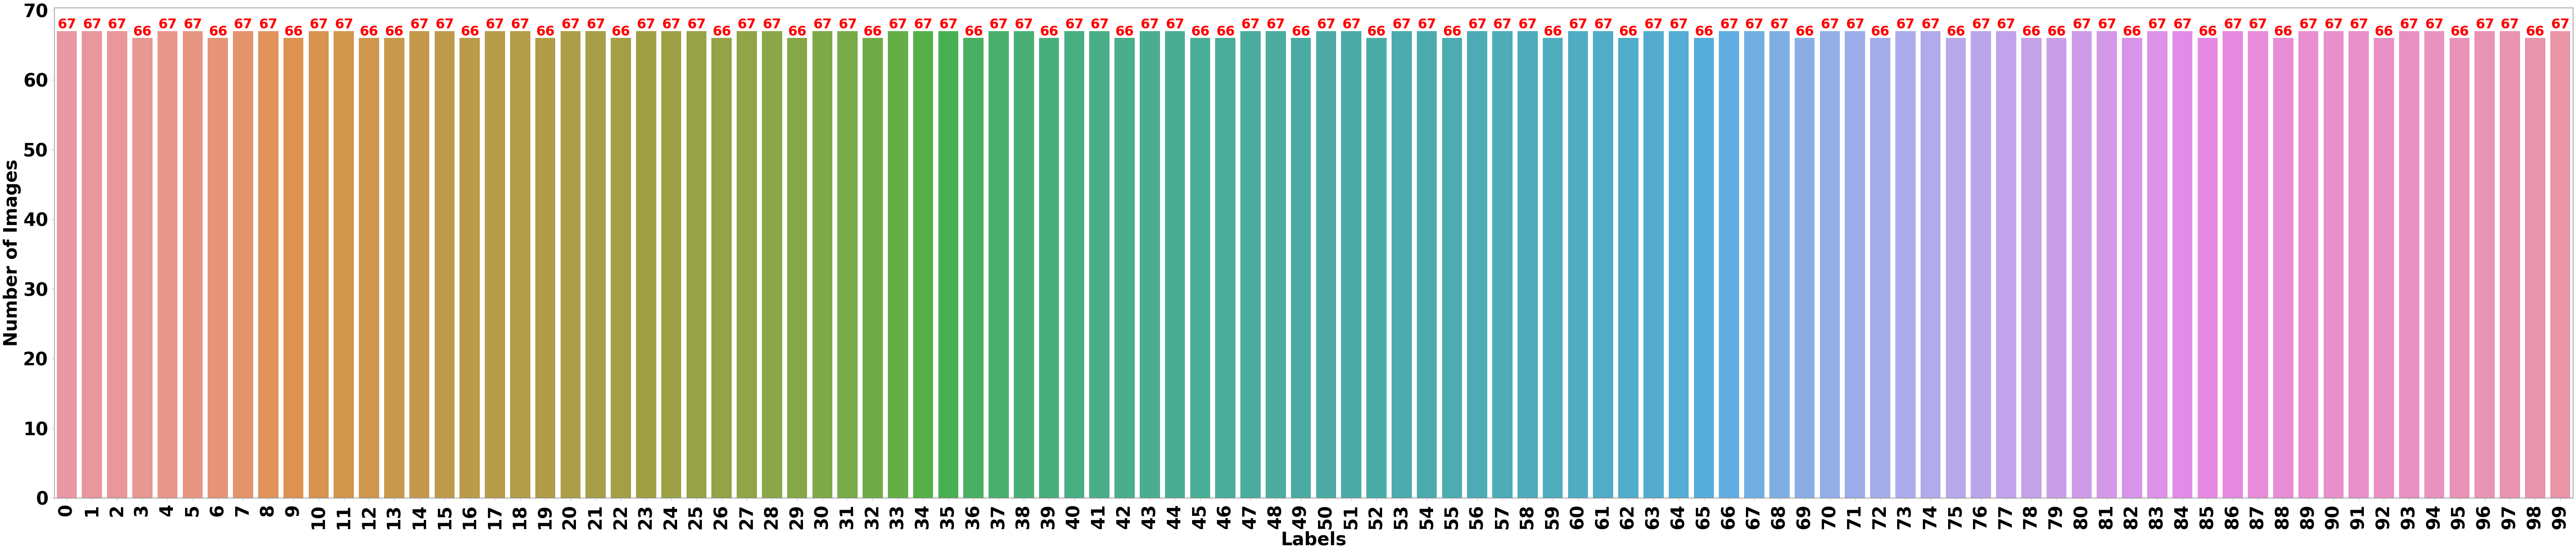

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.facecolor'] = 'white'
lbl = train_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(100,20))
ax = sns.countplot(x= lbl, data=train_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Images Per Catergory

In [7]:
number_classes = train_df['Label'].nunique()
print("Number of classes:", number_classes)
counted = train_df.groupby(["Label"]).size()
print(counted)

Number of classes: 100
Label
0     67
1     67
2     66
3     67
4     67
      ..
95    66
96    67
97    67
98    66
99    67
Length: 100, dtype: int64


# Writing testing  Data into CSV  (Test data frame df)

In [8]:
from pathlib import Path
import os.path
test_dir = "testing"
test_path = Path(test_dir)
filepaths = list(test_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
images = pd.concat([filepaths, labels], axis=1)
test_df = pd.DataFrame(images)
test_df

,Filepath,Label
0,testing/32/1691545.jpg,32
1,testing/32/2212521.jpg,32
2,testing/32/1508910.jpg,32
3,testing/32/1260329.jpg,32
4,testing/32/0199985.jpg,32
...,...,...
3328,testing/42/0773394.jpg,42
3329,testing/42/0875337.jpg,42
3330,testing/42/0759282.jpg,42
3331,testing/42/2228007.jpg,42


In [9]:
test_df['Label'] = test_df['Label'].map(lambda x: x.lower())

In [10]:
sorted_df = test_df.sort_values(by='Label').reset_index(drop=True)
sorted_df

,Filepath,Label
0,testing/0/0789828.jpg,0
1,testing/0/1453508.jpg,0
2,testing/0/0895165.jpg,0
3,testing/0/0536515.jpg,0
4,testing/0/0747566.jpg,0
...,...,...
3328,testing/99/0973160.jpg,99
3329,testing/99/0197892.jpg,99
3330,testing/99/1176955.jpg,99
3331,testing/99/1298910.jpg,99


In [11]:
my_list = sorted_df.Label.unique()

In [12]:
my_dict = {value: index for index, value in enumerate(my_list)}

In [13]:
sorted_df['Label_numeric'] = sorted_df['Label'].map(my_dict)
sorted_df

,Filepath,Label,Label_numeric
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [14]:
test_df = sorted_df[['Filepath', 'Label_numeric', 'Label']]
test_df

,Filepath,Label_numeric,Label
0,testing/0/0789828.jpg,0,0
1,testing/0/1453508.jpg,0,0
2,testing/0/0895165.jpg,0,0
3,testing/0/0536515.jpg,0,0
4,testing/0/0747566.jpg,0,0
...,...,...,...
3328,testing/99/0973160.jpg,99,99
3329,testing/99/0197892.jpg,99,99
3330,testing/99/1176955.jpg,99,99
3331,testing/99/1298910.jpg,99,99


In [15]:
label_counts = sorted_df['Label_numeric'].value_counts().sort_index().tolist()
print(label_counts)

[33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 34, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33, 33, 33, 34, 33, 33, 34, 33, 33, 34, 33]


In [16]:
labels = sorted_df.Label_numeric.tolist()
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

Text(0, 0.5, 'Number of Images')

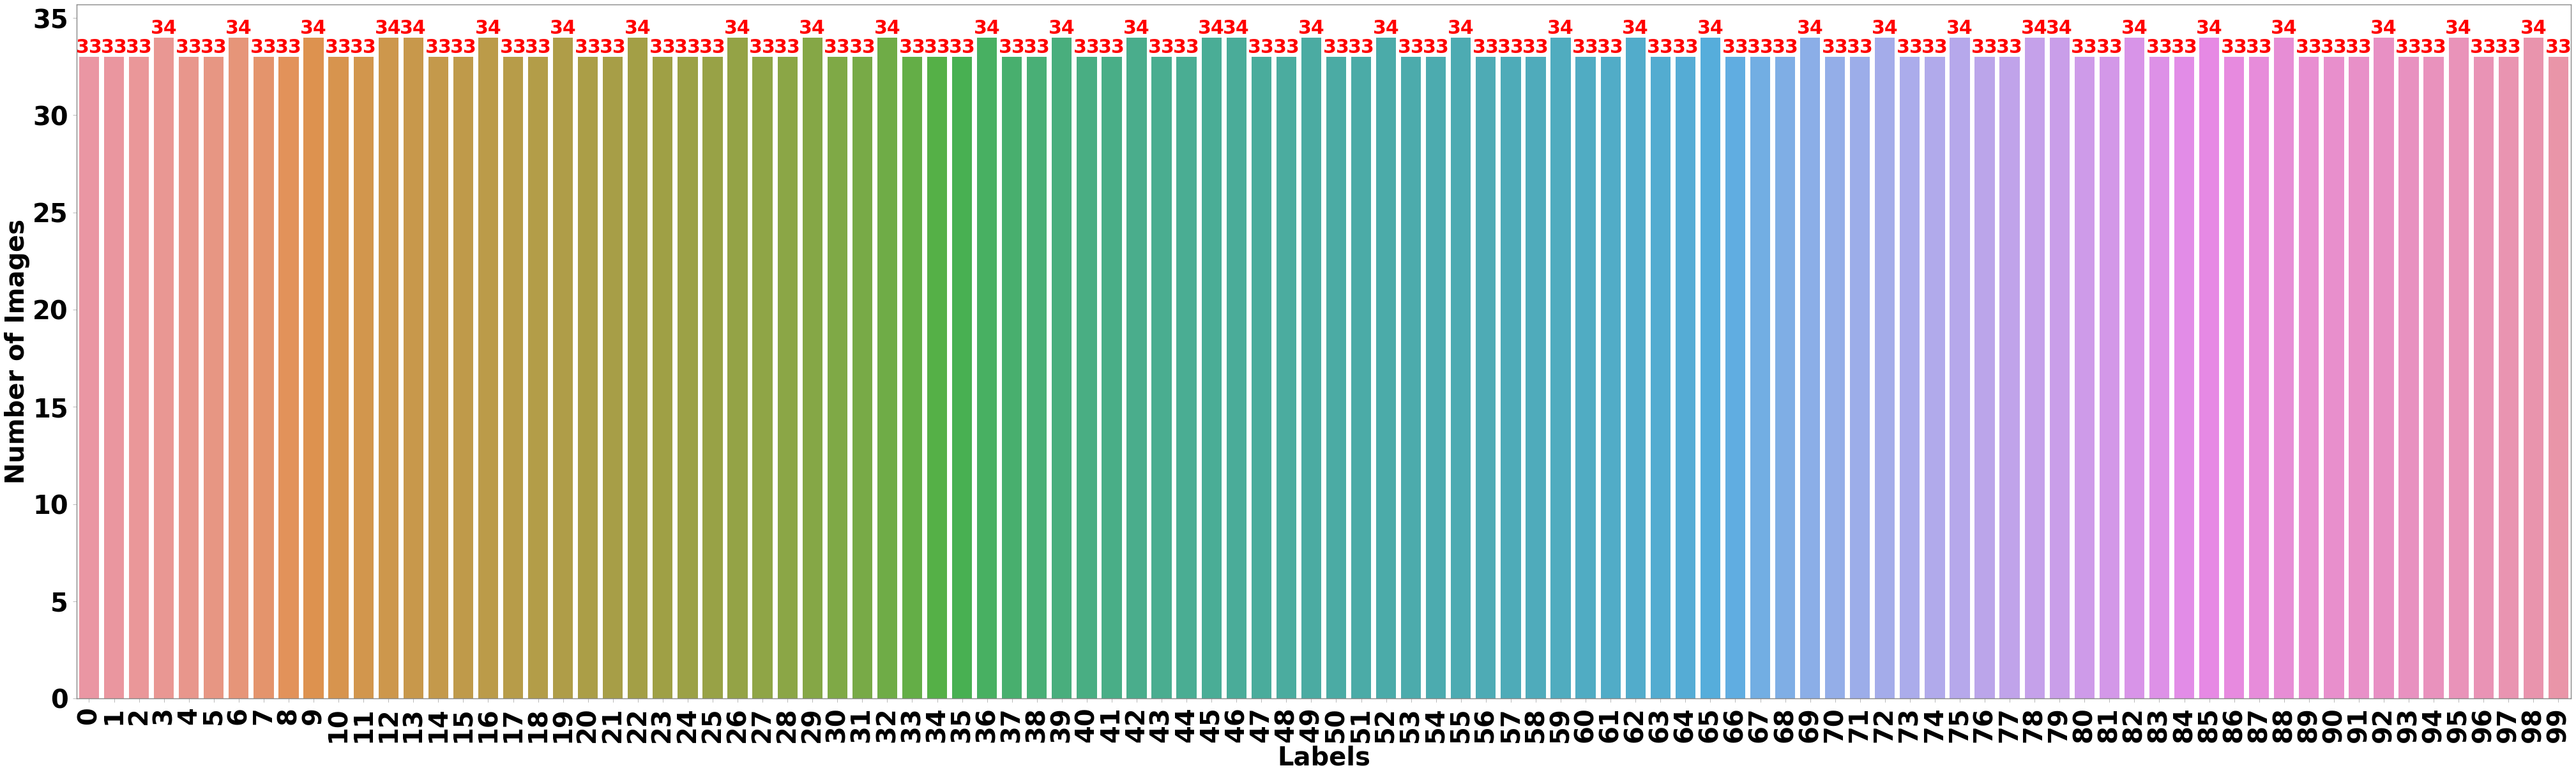

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
lbl = test_df['Label_numeric']
# print(lbl)
# print(lbl.size)
plt.figure(figsize=(70,20))
ax = sns.countplot(x= lbl, data=test_df)
ax.bar_label(ax.containers[0], weight = 'bold', fontsize = '30', color = 'red')
plt.xticks(rotation=90, fontsize = 40, weight = 'bold', color = 'black')
plt.yticks( fontsize = 40, weight = 'bold', color = 'black')
plt.xlabel("Labels", fontsize = 40, weight = 'bold', color = 'black')
plt.ylabel("Number of Images", fontsize = 40, weight = 'bold', color = 'black')

# Import Fastai and pytorch Library

In [18]:
from fastai.vision.all import *
from fastai import __version__
import torch
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from fastai.vision import *
from fastai import optimizer, losses, metrics
from functools import partial, wraps
import matplotlib.pyplot as plt
import random

# Fastai version checking

In [19]:
import fastai
import torchvision
print(fastai.__version__)
print(torch.__version__)
print(torchvision.__version__)

2.6.3
1.11.0
0.12.0


# Torch version checking

In [20]:
import torch
torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()


True

# Preparation of data for learner (Fastai learner)

In [21]:
batch_tfms = [Zoom(),Rotate(), Flip(), Brightness(), Contrast(), Saturation()]

In [22]:

# default augmentation
bs   = batch_size[architecture]
imgs = effnet_size[architecture]
resize = (imgs*4)//3
data0 = (ImageDataLoaders.from_df(train_df, valid_pct=0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

print("Image size=", imgs)
print("Batch size=", bs)
print("Architecture=", architecture)
print(resize)

Image size= 450
Batch size= 16
Architecture= efficientnet-b4
600


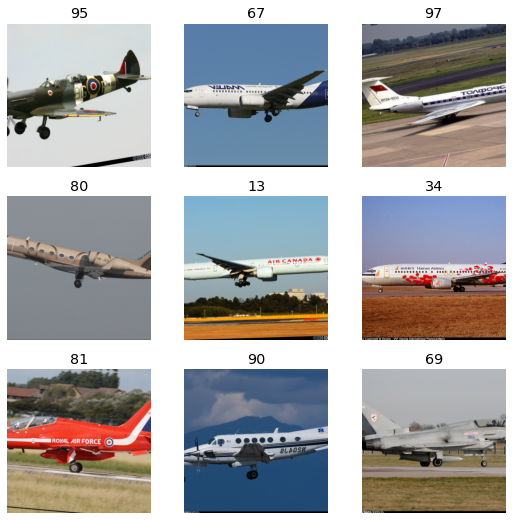

In [23]:
data0.show_batch()

In [24]:
import damped_losses as losses
loss_func = losses.DampedCELossFlat(num_classes=196,delta=0.0,reduction='mean')
model = EfficientNet.from_pretrained(architecture, num_classes=196)
learner_type = Learner

Loaded pretrained weights for efficientnet-b4


In [25]:
best_pth = best_pth
checkpoints = SaveModelCallback(fname=best_pth,monitor='accuracy',comp=np.greater, with_opt=True)
# brainfreeze = BnFreeze()
learn = ( learner_type(data0, model,metrics=[accuracy],loss_func=loss_func,
                        cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
print("Best pth is=", best_pth)

Best pth is= ce_aircrafts_asym_0.3_baseline


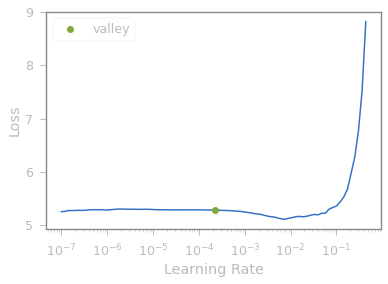

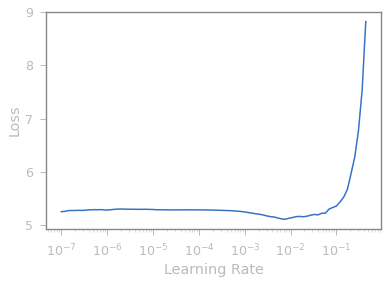

In [30]:
learn.lr_find()
learn.recorder.plot_lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,3.686879,3.154039,0.204801,01:50
1,2.545815,2.671189,0.264066,01:49
2,2.074509,2.932199,0.243811,01:49
3,1.699555,2.183611,0.377344,01:49
4,1.413309,1.716717,0.453113,01:49
5,1.132528,1.503532,0.501125,01:49
6,0.808809,1.501762,0.489122,01:49
7,0.546073,1.443316,0.520630,01:49
8,0.365717,1.448450,0.534884,01:49
9,0.292139,1.447165,0.530383,01:50


Better model found at epoch 0 with accuracy value: 0.20480120182037354.


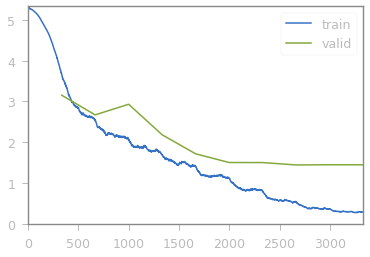

Better model found at epoch 1 with accuracy value: 0.26406601071357727.
Better model found at epoch 3 with accuracy value: 0.3773443400859833.
Better model found at epoch 4 with accuracy value: 0.45311328768730164.
Better model found at epoch 5 with accuracy value: 0.5011252760887146.
Better model found at epoch 7 with accuracy value: 0.5206301808357239.
Better model found at epoch 8 with accuracy value: 0.5348837375640869.


In [31]:
low_lr = 1e-4
lr = 1e-3
learn.fit_one_cycle(10, lr_max = slice(low_lr, lr))

# Unfreeze the Learner
fast.ai freezes the pre-trained part when we create the model. So up to this point, 
we only trained the last layer block. Next, we will unfreeze the pre-trained part and train the whole model.

In [32]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.305430,1.462356,0.531133,01:49
1,0.278270,1.524493,0.526632,01:50
2,0.263420,1.642949,0.516879,01:50
3,0.291791,1.871462,0.519880,01:49
4,0.350343,2.138412,0.471868,01:49
5,0.382063,2.230967,0.485371,01:49
6,0.525924,2.406108,0.445611,01:49
7,0.585168,2.652175,0.423106,01:49
8,0.689690,2.590436,0.427607,01:49
9,0.718418,2.392693,0.453863,01:50


Better model found at epoch 0 with accuracy value: 0.5311327576637268.


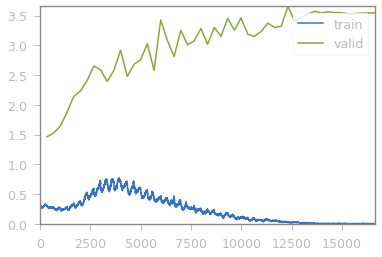

In [33]:
learn.fit_one_cycle(50, lr_max = slice(low_lr, lr))

**Loss plot of the baseline:**
    
Due to the high noise in the data, the baseline struggles both in terms of training loss as well as validation loss as the model tends to overfit easily to the noise.

In [34]:
data_test = (ImageDataLoaders.from_df(test_df, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
preds = learn.get_preds(dl=data_test)
preds
print("length of preds[1]",len(preds[1]))
acc= accuracy(preds[0], preds[1])
print(" BaselineTop-1 Accuracy:", acc)
# inter_test0 = ClassificationInterpretation.from_learner(tester0, dl =data_test)
# inter_test0.plot_confusion_matrix(figsize = (50,60))

length of preds[1] 3333
 BaselineTop-1 Accuracy: TensorBase(0.7045)


 ------------
 B0|Epochs|20|8056   |
 -----------------------------

In [35]:
err = {}
acc = []
log_preds, y  = learn.tta(dl=data_test)
tta_acc = accuracy(log_preds, y)
print(tta_acc)
err[0] = (100.0, 100.0*(1.0-float(tta_acc)))
acc.append(tta_acc)

TensorBase(0.7057)


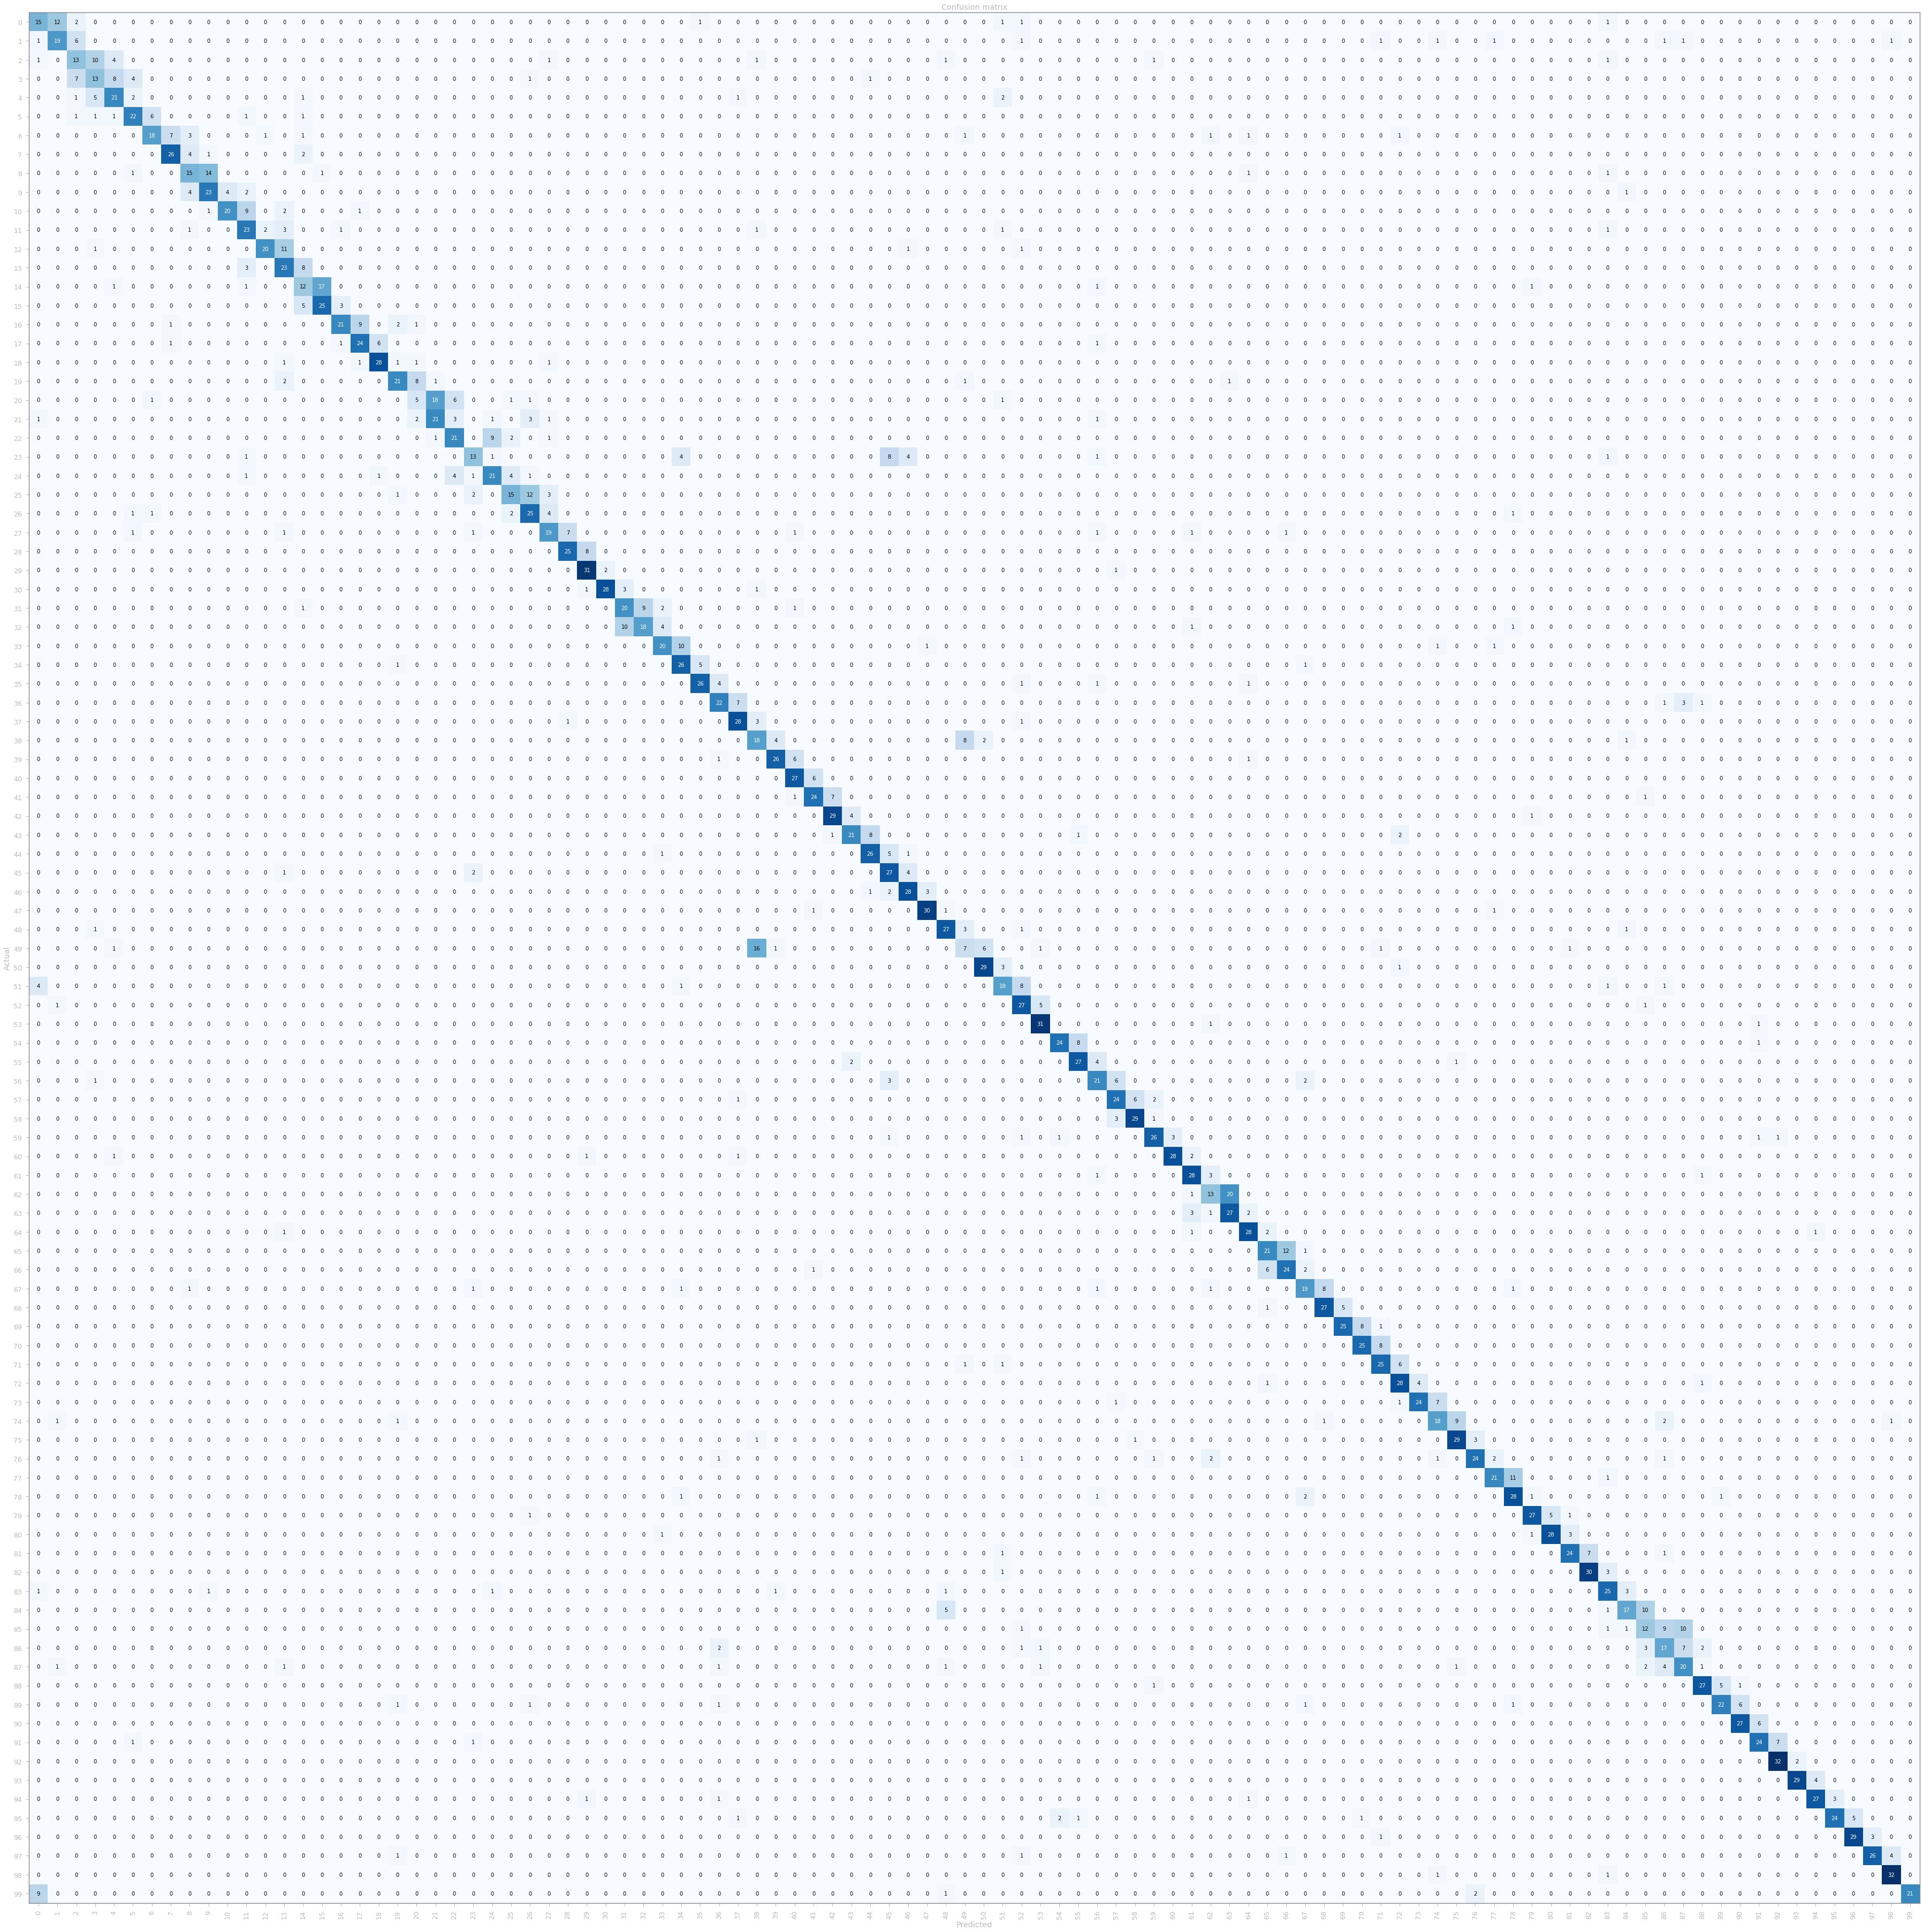

In [36]:
inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
inter_test.plot_confusion_matrix(figsize = (50,50))

In [37]:
PATH='models/'+feature_path+'.p'
torch.save(model.state_dict(), PATH)

In [38]:
# import shutil
import os
# Specify the path of the folder where you want to create the directory
folder_path = 'models'

# Specify the name of the directory you want to create
directory_name = 'baseline'

# Combine the folder path and directory name
new_directory_path = os.path.join(folder_path, directory_name)

# Create the directory
try:
    # Create the directory
    os.makedirs(new_directory_path)
    print(f"Directory '{directory_name}' created inside '{folder_path}'.")
except FileExistsError:
    print(f"Directory '{directory_name}' already exists inside '{folder_path}'.")

# Now, here we copy the best model for baseline and past into the destination, like the folder we created inside the model directory, named "baseline"!!!!!
source = 'models/'+best_pth+'.pth'

destination = 'models/baseline/'+best_pth+'.pth'
# Copy the file from source to destination
shutil.copy(source, destination)

Directory 'baseline' already exists inside 'models'.


'models/baseline/ce_aircrafts_asym_0.3_baseline.pth'

In [26]:
drop_idxx = []
los = []
top_losses = []
k_samples = 100       # Number of samples for top losses filtering

def class_frequencies(data,class_key='Label'):
    classes = set(data[class_key])
    class_freq = {}
    max_freq = 0.5
    min_freq =100000#1000000
    for cl in classes:
        class_df = data[data[class_key]==cl]
        freq = len(class_df)
        max_freq = max(freq,max_freq)
        min_freq = min(freq,min_freq)
        class_freq[cl] = freq
    print(f'Max frequency is {max_freq}')
    print(f'Min frequency is {min_freq}')
    return class_freq,max_freq,min_freq
    

def russian_roulette(idx, losses, data,class_key='Label', min_prob=0.5,max_prob=0.9): #min_prob=0.5,max_prob=0.9 original values
    
    class_freq,max_freq,min_freq = class_frequencies(data,class_key)
    min_prob = float(min_freq/max_freq)*max_prob
    print(f'Min probability = {min_prob}')
    deltap = (max_prob - min_prob)/(max_freq**2)    
    drop_idx = []
    for n,i in enumerate(idx.numpy()):
        l = data.iloc[i][class_key]
        prob = min_prob + (class_freq[l]-min_freq)*deltap
        r = rn.random()
        if  r < prob:
            drop_idx.append(i)
            class_freq[l] -= 1 
    return drop_idx

def data_definition(data,imgs,tfms,model,best_pth,k_samples=k_samples, min_prob=0.4, max_prob = 0.9, largest=True): # k_sample = 1000
    databunch = ( ImageDataLoaders.from_df(data, valid_pct=0.0, bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))
    learn_cln = (learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func, cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
    learn_cln.load(best_pth)
    entire_training_set_csv0 = (ImageDataLoaders.from_df(data, valid_pct = 0.0, splitter=None, shuffle=False, label_col=1, item_tfms=Resize(imgs)))
    interp = ClassificationInterpretation.from_learner(learn_cln, dl = entire_training_set_csv0)
    losses = None
    idx = None
    if hybrid:
        l_big,idx_big = interp.top_losses(k_samples//2,largest=True)
        l_sm,idx_sm = interp.top_losses(k_samples//2,largest=False)
        losses = torch.cat((l_big,l_sm),0)
        idx = torch.cat((idx_big,idx_sm),0)
    else:
        losses,idx = interp.top_losses(k_samples,largest=largest)
    drop_idx = russian_roulette(idx,losses,data,min_prob = min_prob, max_prob = max_prob)
    data_filtered = data.drop(data.index[drop_idx])
    print(f'Dropped {len(drop_idx)} top losses')
    return data_filtered

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 92 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6575


epoch,train_loss,valid_loss,accuracy,time
0,0.358066,0.218156,0.900380,01:46


Better model found at epoch 0 with accuracy value: 0.9003802537918091.


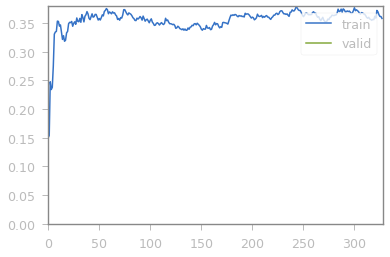

************Round:  0
TTA Accuracy:0.722172200679779
cycle 0 Error Rate is [{0: (1.3799310034498302, 27.782779932022095)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 85 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6490


epoch,train_loss,valid_loss,accuracy,time
0,0.314668,0.185964,0.902928,01:47


Better model found at epoch 0 with accuracy value: 0.902927577495575.


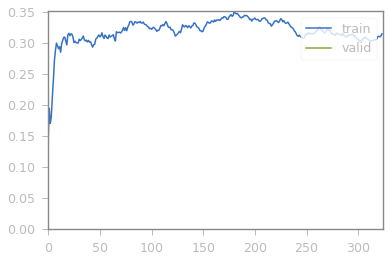

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 87 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6403


epoch,train_loss,valid_loss,accuracy,time
0,0.269040,0.175617,0.893750,01:45


Better model found at epoch 0 with accuracy value: 0.893750011920929.


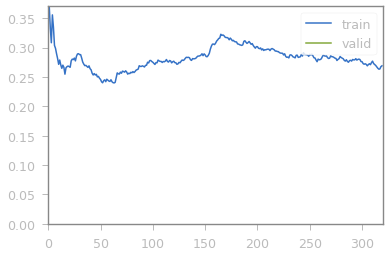

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 77 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6326


epoch,train_loss,valid_loss,accuracy,time
0,0.241536,0.148993,0.892490,01:44


Better model found at epoch 0 with accuracy value: 0.8924900889396667.


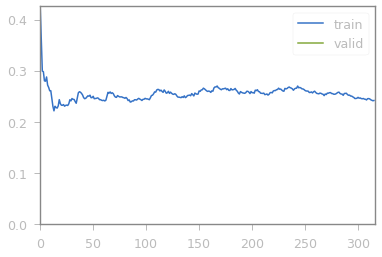

************Round:  3
TTA Accuracy:0.7350735068321228
cycle 0 Error Rate is [{0: (1.3799310034498302, 27.782779932022095), 3: (5.114744262786863, 26.49264931678772)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 81 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6245


epoch,train_loss,valid_loss,accuracy,time
0,0.249895,0.133284,0.905524,01:42


Better model found at epoch 0 with accuracy value: 0.9055244326591492.


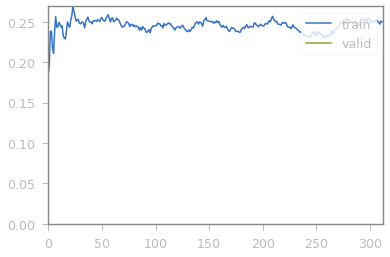

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 58
Min probability = 0.7791044776119402
Dropped 84 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6161


epoch,train_loss,valid_loss,accuracy,time
0,0.227396,0.121914,0.899351,01:41


Better model found at epoch 0 with accuracy value: 0.899350643157959.


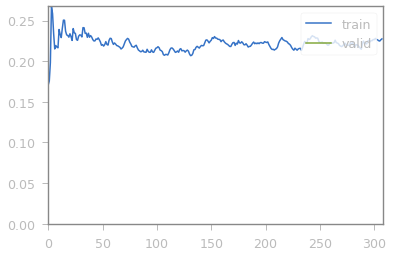

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 65
Min frequency is 57
Min probability = 0.7892307692307693
Dropped 86 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6075


epoch,train_loss,valid_loss,accuracy,time
0,0.210426,0.116235,0.897942,01:41


Better model found at epoch 0 with accuracy value: 0.8979423642158508.


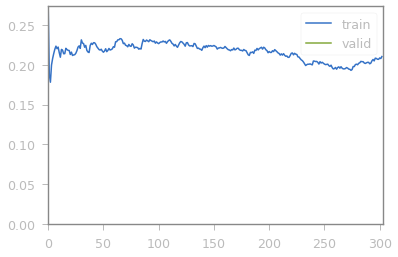

************Round:  6
TTA Accuracy:0.737473726272583
cycle 0 Error Rate is [{0: (1.3799310034498302, 27.782779932022095), 3: (5.114744262786863, 26.49264931678772), 6: (8.879556022198887, 26.2526273727417)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 65
Min frequency is 56
Min probability = 0.7753846153846154
Dropped 77 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
5998


epoch,train_loss,valid_loss,accuracy,time
0,0.191002,0.120222,0.883236,01:38


Better model found at epoch 0 with accuracy value: 0.8832360506057739.


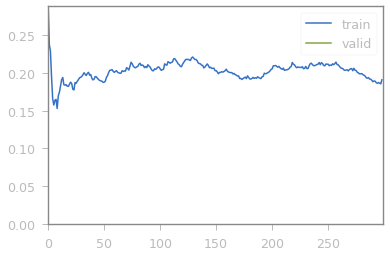

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 65
Min frequency is 55
Min probability = 0.7615384615384615
Dropped 73 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5925


epoch,train_loss,valid_loss,accuracy,time
0,0.202107,0.091601,0.902110,01:37


Better model found at epoch 0 with accuracy value: 0.902109682559967.


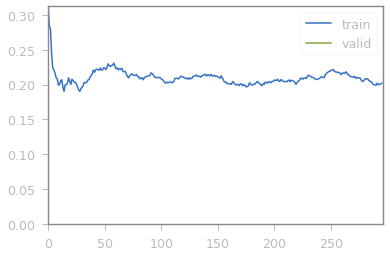

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 80 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5845


epoch,train_loss,valid_loss,accuracy,time
0,0.195134,0.111925,0.882806,01:36


Better model found at epoch 0 with accuracy value: 0.8828058242797852.


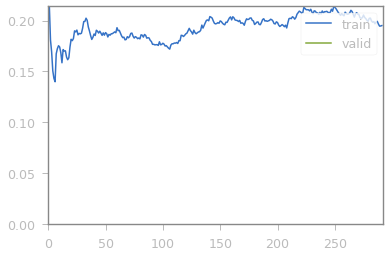

************Round:  9
TTA Accuracy:0.7362736463546753
cycle 0 Error Rate is [{0: (1.3799310034498302, 27.782779932022095), 3: (5.114744262786863, 26.49264931678772), 6: (8.879556022198887, 26.2526273727417), 9: (12.329383530823456, 26.37263536453247)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 64
Min frequency is 52
Min probability = 0.7312500000000001
Dropped 71 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5774


epoch,train_loss,valid_loss,accuracy,time
0,0.197814,0.100860,0.900347,01:35


Better model found at epoch 0 with accuracy value: 0.9003466367721558.


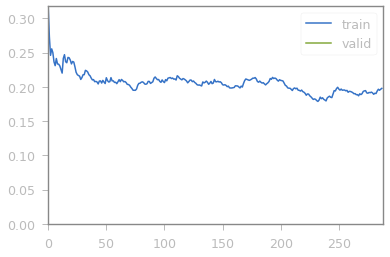

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 63
Min frequency is 52
Min probability = 0.7428571428571429
Dropped 79 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5695


epoch,train_loss,valid_loss,accuracy,time
0,0.205000,0.104128,0.884109,01:33


Better model found at epoch 0 with accuracy value: 0.88410884141922.


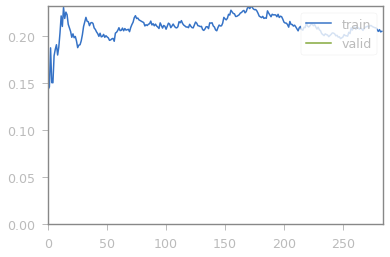

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 62
Min frequency is 51
Min probability = 0.7403225806451613
Dropped 81 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5614


epoch,train_loss,valid_loss,accuracy,time
0,0.229877,0.110942,0.886809,01:32


Better model found at epoch 0 with accuracy value: 0.8868092894554138.


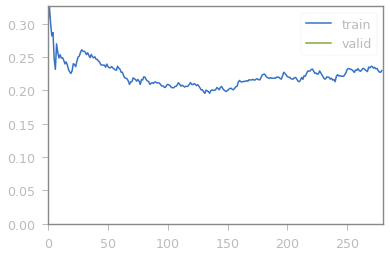

************Round:  12
TTA Accuracy:0.7386738657951355
cycle 0 Error Rate is [{0: (1.3799310034498302, 27.782779932022095), 3: (5.114744262786863, 26.49264931678772), 6: (8.879556022198887, 26.2526273727417), 9: (12.329383530823456, 26.37263536453247), 12: (15.794210289485521, 26.13261342048645)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 62
Min frequency is 51
Min probability = 0.7403225806451613
Dropped 73 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5541


epoch,train_loss,valid_loss,accuracy,time
0,0.250437,0.131860,0.891697,01:32


Better model found at epoch 0 with accuracy value: 0.8916967511177063.


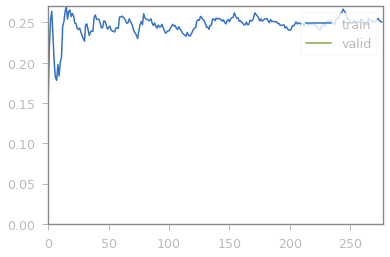

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 61
Min frequency is 49
Min probability = 0.7229508196721312
Dropped 73 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5468


epoch,train_loss,valid_loss,accuracy,time
0,0.580391,0.479381,0.908509,01:30


Better model found at epoch 0 with accuracy value: 0.9085087180137634.


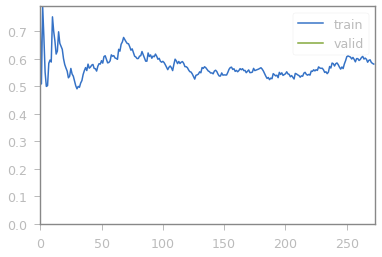

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 86 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6581


epoch,train_loss,valid_loss,accuracy,time
0,0.250524,0.139474,0.889818,01:48


Better model found at epoch 0 with accuracy value: 0.8898176550865173.


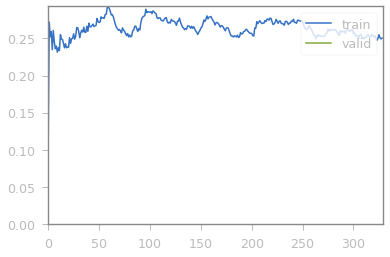

************Round:  0
TTA Accuracy:0.7380738258361816
cycle 1 Error Rate is [{0: (1.3799310034498302, 27.782779932022095), 3: (5.114744262786863, 26.49264931678772), 6: (8.879556022198887, 26.2526273727417), 9: (12.329383530823456, 26.37263536453247), 12: (15.794210289485521, 26.13261342048645), 15: (1.2899355032248372, 26.192617416381836)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 78 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6503


epoch,train_loss,valid_loss,accuracy,time
0,0.210273,0.089149,0.899231,01:47


Better model found at epoch 0 with accuracy value: 0.8992307782173157.


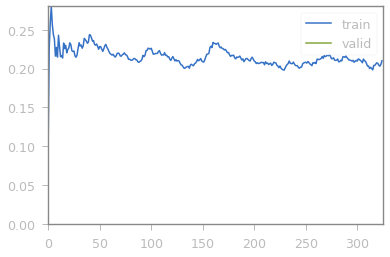

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 81 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6422


epoch,train_loss,valid_loss,accuracy,time
0,0.186263,0.092890,0.904206,01:45


Better model found at epoch 0 with accuracy value: 0.9042056202888489.


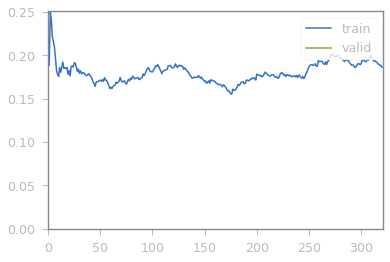

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 80 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6342


epoch,train_loss,valid_loss,accuracy,time
0,0.173172,0.073158,0.893533,01:44


Better model found at epoch 0 with accuracy value: 0.8935331106185913.


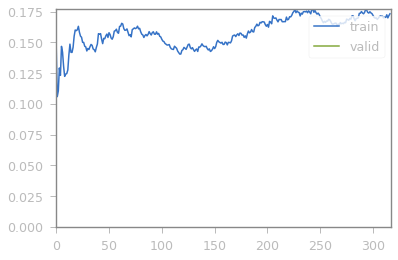

************Round:  3
TTA Accuracy:0.7347734570503235
cycle 1 Error Rate is [{0: (1.3799310034498302, 27.782779932022095), 3: (5.114744262786863, 26.49264931678772), 6: (8.879556022198887, 26.2526273727417), 9: (12.329383530823456, 26.37263536453247), 12: (15.794210289485521, 26.13261342048645), 15: (1.2899355032248372, 26.192617416381836), 18: (4.874756262186885, 26.52265429496765)}]
+++++ Training serie: inverse pyramid 4 ++++++++


RuntimeError: CUDA out of memory. Tried to allocate 2.62 GiB (GPU 0; 10.75 GiB total capacity; 785.16 MiB already allocated; 2.63 GiB free; 6.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [44]:
# Define required parameters and lists
n_training_series = 15  # Number of training series for scheme, means iteration in a single cycle
cleaning_cycles = 3   # Number of cleaning cycles for scheme
delta_max = 0.25       # Max delta value for scheme, damping factor value
min_epochs = 1         # number of loop in a single training of series 
min_lr = 1e-4          # for dynamic learning rates, if use.
kappa_lr = 1           # for dynamic learning rates, if use.
min_prob = 0.5         # probability of min classes.
max_prob = 0.9         # probability of max classes.
delta_epochs_per_serie = 0   # change in number of epochs
data_per_serie = {}
data_per_serie[0] = train_df
largest = True
from_scratch = False
hybrid = False
accs = []
deltas = []
err = {}

for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
        loss_func = losses.DampedCELossFlat(num_classes=196,delta=delta, reduction='mean')      
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
        learn.unfreeze() 
        learn.load(best_pth)
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            acc.append(tta_acc)
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
            PATH='models/'+damp_1_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_1_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()


+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 91 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6576


epoch,train_loss,valid_loss,accuracy,time
0,0.191769,0.087105,0.904943,01:54


Better model found at epoch 0 with accuracy value: 0.9049429893493652.


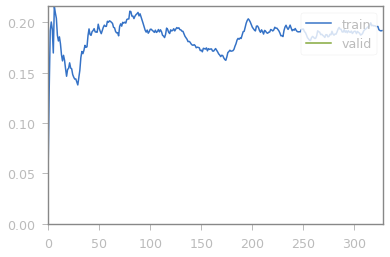

************Round:  0
TTA Accuracy:0.7308731079101562
cycle 0 Error Rate is [{0: (1.364931753412324, 26.912689208984375)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 89 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6487


epoch,train_loss,valid_loss,accuracy,time
0,0.146898,0.073283,0.895914,01:47


Better model found at epoch 0 with accuracy value: 0.8959136605262756.


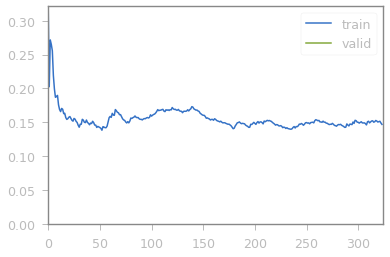

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 85 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6402


epoch,train_loss,valid_loss,accuracy,time
0,0.129801,0.055562,0.911719,01:44


Better model found at epoch 0 with accuracy value: 0.9117187261581421.


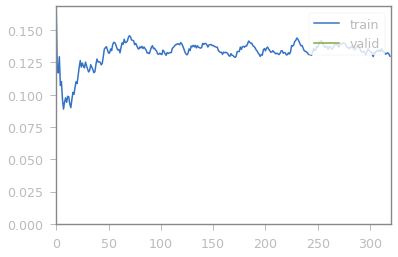

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 60
Min probability = 0.8059701492537313
Dropped 81 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6321


epoch,train_loss,valid_loss,accuracy,time
0,0.117432,0.050881,0.896361,01:44


Better model found at epoch 0 with accuracy value: 0.8963607549667358.


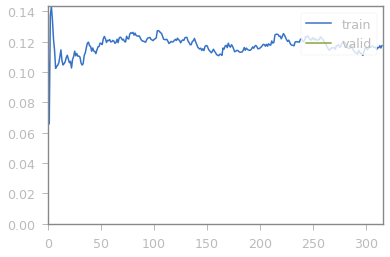

************Round:  3
TTA Accuracy:0.7476747632026672
cycle 0 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 66
Min frequency is 59
Min probability = 0.8045454545454546
Dropped 80 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6241


epoch,train_loss,valid_loss,accuracy,time
0,0.103835,0.045819,0.904647,01:42


Better model found at epoch 0 with accuracy value: 0.9046474099159241.


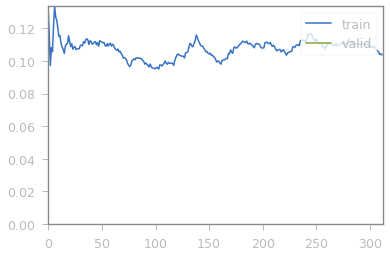

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 58
Min probability = 0.7909090909090909
Dropped 82 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6159


epoch,train_loss,valid_loss,accuracy,time
0,0.103711,0.037287,0.891958,01:43


Better model found at epoch 0 with accuracy value: 0.8919577598571777.


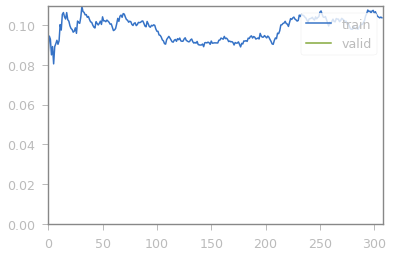

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 55
Min probability = 0.75
Dropped 73 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6086


epoch,train_loss,valid_loss,accuracy,time
0,0.098391,0.034939,0.895645,01:40


Better model found at epoch 0 with accuracy value: 0.895645022392273.


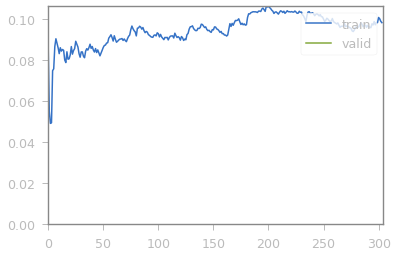

************Round:  6
TTA Accuracy:0.7506750822067261
cycle 0 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 66
Min frequency is 53
Min probability = 0.7227272727272727
Dropped 69 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6017


epoch,train_loss,valid_loss,accuracy,time
0,0.091679,0.033688,0.884456,01:38


Better model found at epoch 0 with accuracy value: 0.8844555020332336.


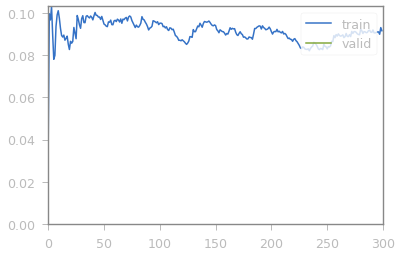

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 74 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5943


epoch,train_loss,valid_loss,accuracy,time
0,0.089624,0.041775,0.877946,01:39


Better model found at epoch 0 with accuracy value: 0.877946138381958.


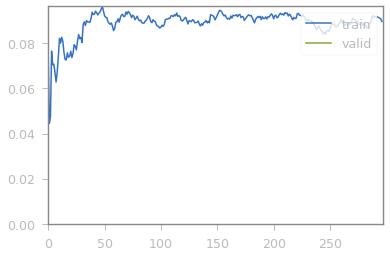

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 64
Min frequency is 53
Min probability = 0.7453125
Dropped 79 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5864


epoch,train_loss,valid_loss,accuracy,time
0,0.087073,0.033715,0.879693,01:36


Better model found at epoch 0 with accuracy value: 0.8796928524971008.


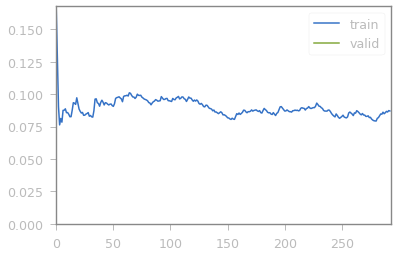

************Round:  9
TTA Accuracy:0.7611761093139648
cycle 0 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 64
Min frequency is 52
Min probability = 0.7312500000000001
Dropped 82 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5782


epoch,train_loss,valid_loss,accuracy,time
0,0.087621,0.032937,0.891003,01:35


Better model found at epoch 0 with accuracy value: 0.8910034894943237.


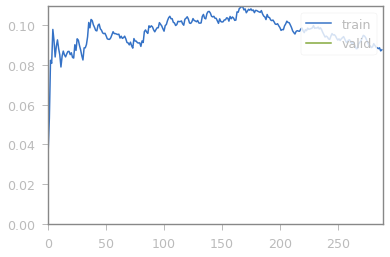

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 63
Min frequency is 52
Min probability = 0.7428571428571429
Dropped 68 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5714


epoch,train_loss,valid_loss,accuracy,time
0,0.113867,0.040158,0.887916,01:34


Better model found at epoch 0 with accuracy value: 0.8879159092903137.


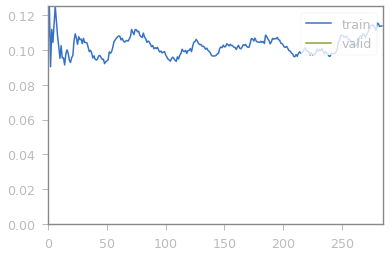

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 63
Min frequency is 51
Min probability = 0.7285714285714286
Dropped 71 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5643


epoch,train_loss,valid_loss,accuracy,time
0,0.114961,0.036671,0.895390,01:35


Better model found at epoch 0 with accuracy value: 0.8953900933265686.


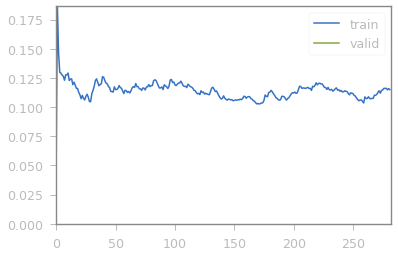

************Round:  12
TTA Accuracy:0.7461746335029602
cycle 0 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 63
Min frequency is 50
Min probability = 0.7142857142857143
Dropped 66 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5577


epoch,train_loss,valid_loss,accuracy,time
0,0.123585,0.040442,0.910314,01:31


Better model found at epoch 0 with accuracy value: 0.9103139042854309.


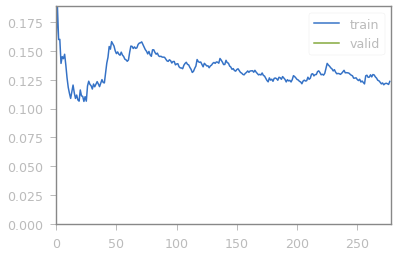

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 62
Min frequency is 47
Min probability = 0.682258064516129
Dropped 73 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5504


epoch,train_loss,valid_loss,accuracy,time
0,0.588712,0.669397,0.898182,01:32


Better model found at epoch 0 with accuracy value: 0.8981817960739136.


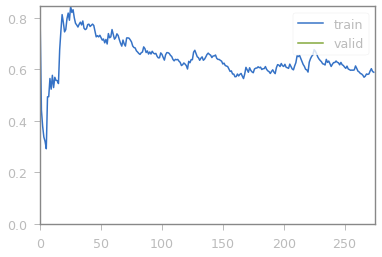

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 89 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6578


epoch,train_loss,valid_loss,accuracy,time
0,0.147452,0.062912,0.900380,01:47


Better model found at epoch 0 with accuracy value: 0.9003802537918091.


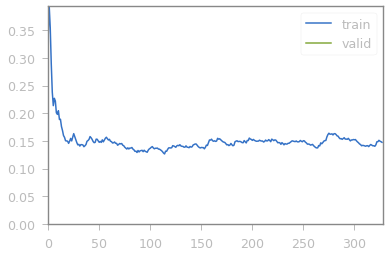

************Round:  0
TTA Accuracy:0.7362736463546753
cycle 1 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 83 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6495


epoch,train_loss,valid_loss,accuracy,time
0,0.111804,0.043517,0.901463,01:46


Better model found at epoch 0 with accuracy value: 0.9014626741409302.


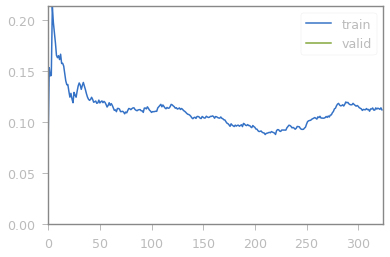

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 82 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6413


epoch,train_loss,valid_loss,accuracy,time
0,0.087558,0.034864,0.896256,01:45


Better model found at epoch 0 with accuracy value: 0.8962558507919312.


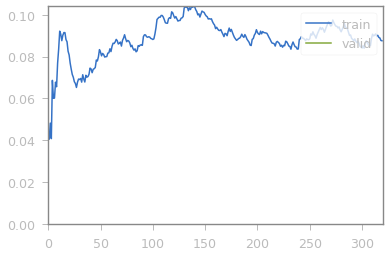

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 82 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6331


epoch,train_loss,valid_loss,accuracy,time
0,0.077032,0.029460,0.894155,01:44


Better model found at epoch 0 with accuracy value: 0.8941548466682434.


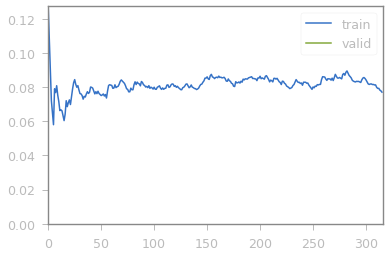

************Round:  3
TTA Accuracy:0.752775251865387
cycle 1 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 77 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6254


epoch,train_loss,valid_loss,accuracy,time
0,0.081220,0.027299,0.889600,01:42


Better model found at epoch 0 with accuracy value: 0.8895999789237976.


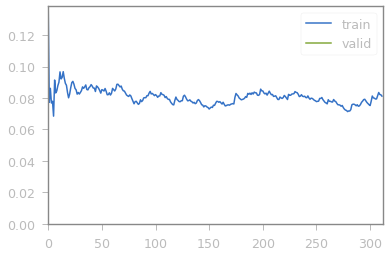

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 67
Min frequency is 57
Min probability = 0.7656716417910449
Dropped 66 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6188


epoch,train_loss,valid_loss,accuracy,time
0,0.073993,0.020166,0.902991,01:41


Better model found at epoch 0 with accuracy value: 0.9029911160469055.


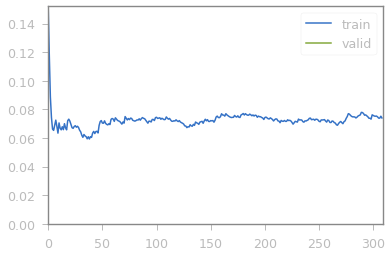

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 77 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6111


epoch,train_loss,valid_loss,accuracy,time
0,0.072630,0.022524,0.889525,01:40


Better model found at epoch 0 with accuracy value: 0.8895253539085388.


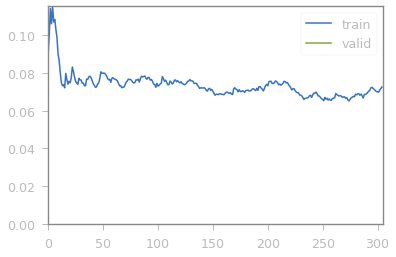

************Round:  6
TTA Accuracy:0.7572757005691528
cycle 1 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 65
Min frequency is 54
Min probability = 0.7476923076923078
Dropped 72 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6039


epoch,train_loss,valid_loss,accuracy,time
0,0.062396,0.022955,0.898923,01:41


Better model found at epoch 0 with accuracy value: 0.8989229202270508.


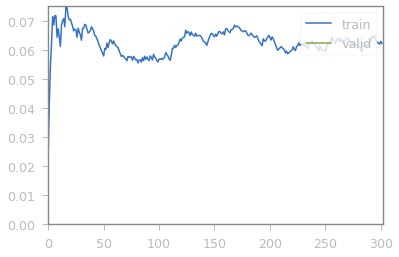

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 78 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5961


epoch,train_loss,valid_loss,accuracy,time
0,0.068409,0.020543,0.898490,01:38


Better model found at epoch 0 with accuracy value: 0.8984899520874023.


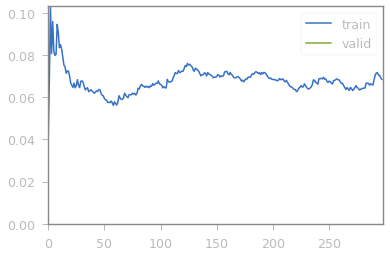

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 73 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5888


epoch,train_loss,valid_loss,accuracy,time
0,0.063868,0.020843,0.898896,01:37


Better model found at epoch 0 with accuracy value: 0.8988955020904541.


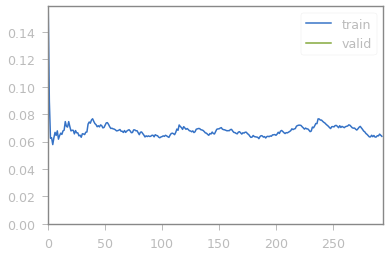

************Round:  9
TTA Accuracy:0.7482748031616211
cycle 1 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717), 24: (11.684415779211044, 25.17251968383789)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 64
Min frequency is 51
Min probability = 0.7171875
Dropped 73 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5815


epoch,train_loss,valid_loss,accuracy,time
0,0.061677,0.019293,0.888220,01:36


Better model found at epoch 0 with accuracy value: 0.8882201313972473.


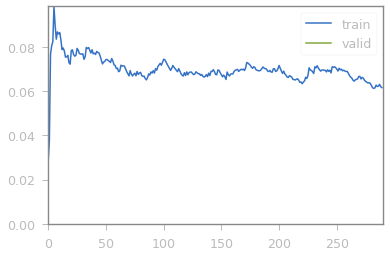

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 63
Min frequency is 49
Min probability = 0.7000000000000001
Dropped 71 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5744


epoch,train_loss,valid_loss,accuracy,time
0,0.070121,0.017384,0.898084,01:35


Better model found at epoch 0 with accuracy value: 0.8980836272239685.


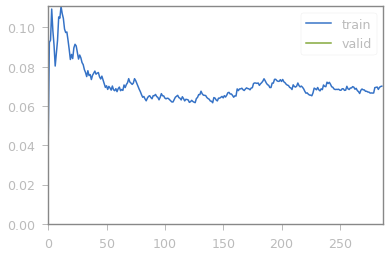

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 63
Min frequency is 49
Min probability = 0.7000000000000001
Dropped 75 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5669


epoch,train_loss,valid_loss,accuracy,time
0,0.080159,0.022603,0.900265,01:34


Better model found at epoch 0 with accuracy value: 0.9002647995948792.


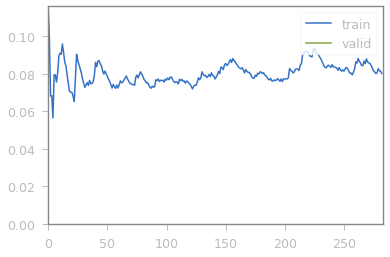

************Round:  12
TTA Accuracy:0.7434743642807007
cycle 1 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717), 24: (11.684415779211044, 25.17251968383789), 27: (14.969251537423133, 25.65256357192993)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 63
Min frequency is 48
Min probability = 0.6857142857142857
Dropped 70 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5599


epoch,train_loss,valid_loss,accuracy,time
0,0.091886,0.039777,0.894549,01:32


Better model found at epoch 0 with accuracy value: 0.8945487141609192.


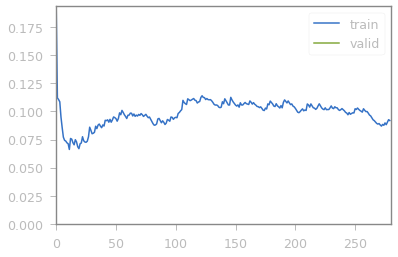

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 47
Min probability = 0.6714285714285715
Dropped 63 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5536


epoch,train_loss,valid_loss,accuracy,time
0,0.594189,0.582553,0.905149,01:31


Better model found at epoch 0 with accuracy value: 0.9051490426063538.


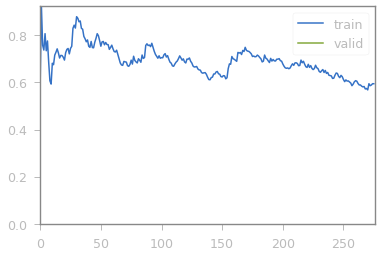

+++++ Training serie: inverse pyramid 0 ++++++++


Max frequency is 67
Min frequency is 66
Min probability = 0.8865671641791044
Dropped 87 top losses
************Round:  0
************data per serie:******************
************length of data per serie:******************
6580


epoch,train_loss,valid_loss,accuracy,time
0,0.118879,0.043581,0.893617,01:48


Better model found at epoch 0 with accuracy value: 0.8936170339584351.


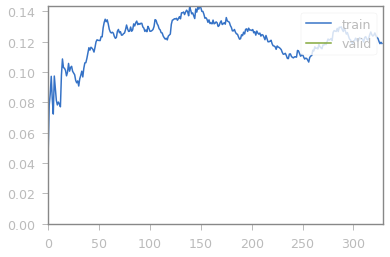

************Round:  0
TTA Accuracy:0.7443744540214539
cycle 2 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717), 24: (11.684415779211044, 25.17251968383789), 27: (14.969251537423133, 25.65256357192993), 30: (1.3049347532623323, 25.562554597854614)}]
+++++ Training serie: inverse pyramid 1 ++++++++


Max frequency is 67
Min frequency is 63
Min probability = 0.8462686567164179
Dropped 85 top losses
************Round:  1
************data per serie:******************
************length of data per serie:******************
6495


epoch,train_loss,valid_loss,accuracy,time
0,0.082133,0.025672,0.899153,01:46


Better model found at epoch 0 with accuracy value: 0.8991531729698181.


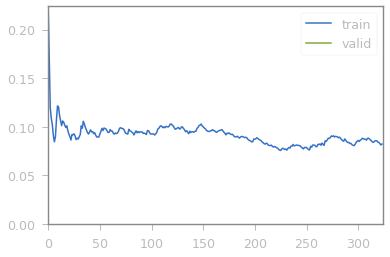

+++++ Training serie: inverse pyramid 2 ++++++++


Max frequency is 67
Min frequency is 62
Min probability = 0.8328358208955224
Dropped 80 top losses
************Round:  2
************data per serie:******************
************length of data per serie:******************
6415


epoch,train_loss,valid_loss,accuracy,time
0,0.068156,0.020704,0.908028,01:45


Better model found at epoch 0 with accuracy value: 0.9080280661582947.


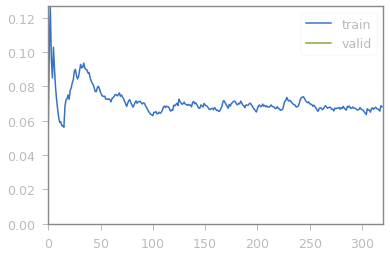

+++++ Training serie: inverse pyramid 3 ++++++++


Max frequency is 67
Min frequency is 61
Min probability = 0.8194029850746268
Dropped 80 top losses
************Round:  3
************data per serie:******************
************length of data per serie:******************
6335


epoch,train_loss,valid_loss,accuracy,time
0,0.065209,0.015159,0.900553,01:44


Better model found at epoch 0 with accuracy value: 0.90055251121521.


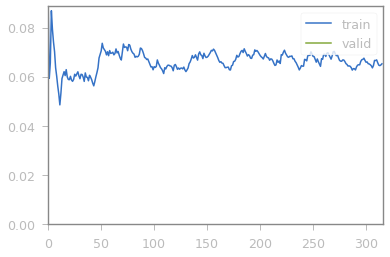

************Round:  3
TTA Accuracy:0.7449744939804077
cycle 2 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717), 24: (11.684415779211044, 25.17251968383789), 27: (14.969251537423133, 25.65256357192993), 30: (1.3049347532623323, 25.562554597854614), 33: (4.979751012449373, 25.50255060195923)}]
+++++ Training serie: inverse pyramid 4 ++++++++


Max frequency is 67
Min frequency is 59
Min probability = 0.7925373134328358
Dropped 83 top losses
************Round:  4
************data per serie:******************
************length of data per serie:******************
6252


epoch,train_loss,valid_loss,accuracy,time
0,0.057224,0.016564,0.903200,01:42


Better model found at epoch 0 with accuracy value: 0.9031999707221985.


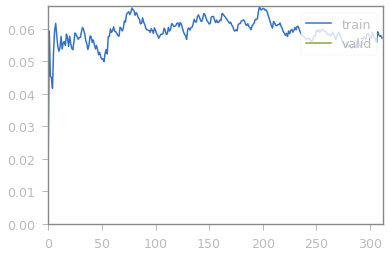

+++++ Training serie: inverse pyramid 5 ++++++++


Max frequency is 66
Min frequency is 58
Min probability = 0.7909090909090909
Dropped 82 top losses
************Round:  5
************data per serie:******************
************length of data per serie:******************
6170


epoch,train_loss,valid_loss,accuracy,time
0,0.051600,0.013199,0.898703,01:41


Better model found at epoch 0 with accuracy value: 0.898703396320343.


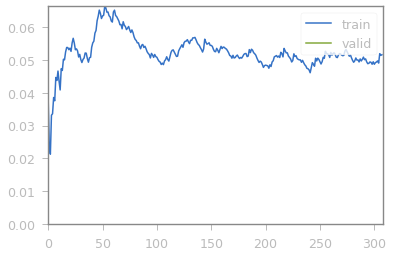

+++++ Training serie: inverse pyramid 6 ++++++++


Max frequency is 66
Min frequency is 56
Min probability = 0.7636363636363637
Dropped 80 top losses
************Round:  6
************data per serie:******************
************length of data per serie:******************
6090


epoch,train_loss,valid_loss,accuracy,time
0,0.055912,0.013331,0.887521,01:40


Better model found at epoch 0 with accuracy value: 0.8875205516815186.


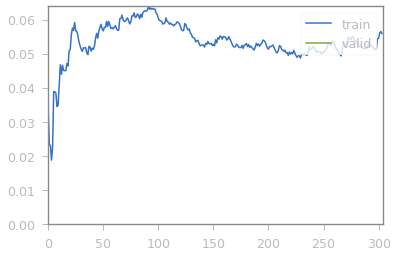

************Round:  6
TTA Accuracy:0.7389739155769348
cycle 2 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717), 24: (11.684415779211044, 25.17251968383789), 27: (14.969251537423133, 25.65256357192993), 30: (1.3049347532623323, 25.562554597854614), 33: (4.979751012449373, 25.50255060195923), 36: (8.654567271636415, 26.10260844230652)}]
+++++ Training serie: inverse pyramid 7 ++++++++


Max frequency is 65
Min frequency is 53
Min probability = 0.7338461538461538
Dropped 79 top losses
************Round:  7
************data per serie:******************
************length of data per serie:******************
6011


epoch,train_loss,valid_loss,accuracy,time
0,0.058230,0.014681,0.896007,01:39


Better model found at epoch 0 with accuracy value: 0.8960066437721252.


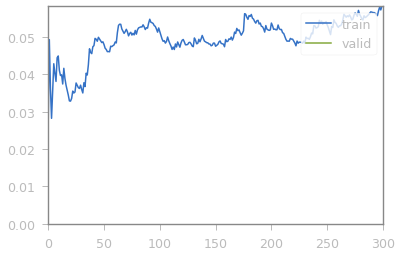

+++++ Training serie: inverse pyramid 8 ++++++++


Max frequency is 65
Min frequency is 50
Min probability = 0.6923076923076924
Dropped 74 top losses
************Round:  8
************data per serie:******************
************length of data per serie:******************
5937


epoch,train_loss,valid_loss,accuracy,time
0,0.051770,0.014111,0.897220,01:38


Better model found at epoch 0 with accuracy value: 0.8972198963165283.


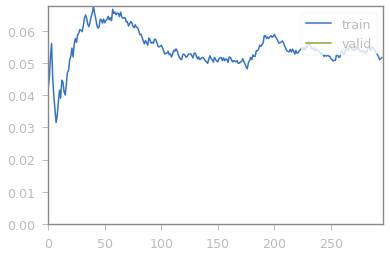

+++++ Training serie: inverse pyramid 9 ++++++++


Max frequency is 64
Min frequency is 50
Min probability = 0.703125
Dropped 69 top losses
************Round:  9
************data per serie:******************
************length of data per serie:******************
5868


epoch,train_loss,valid_loss,accuracy,time
0,0.054869,0.014367,0.904518,01:37


Better model found at epoch 0 with accuracy value: 0.9045183062553406.


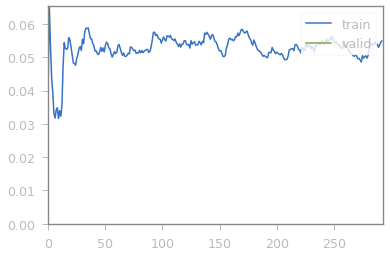

************Round:  9
TTA Accuracy:0.7386738657951355
cycle 2 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717), 24: (11.684415779211044, 25.17251968383789), 27: (14.969251537423133, 25.65256357192993), 30: (1.3049347532623323, 25.562554597854614), 33: (4.979751012449373, 25.50255060195923), 36: (8.654567271636415, 26.10260844230652), 39: (11.984400779961002, 26.13261342048645)}]
+++++ Training serie: inverse pyramid 10 ++++++++


Max frequency is 64
Min frequency is 49
Min probability = 0.6890625
Dropped 64 top losses
************Round:  10
************data per serie:******************
************length of data per serie:******************
5804


epoch,train_loss,valid_loss,accuracy,time
0,0.052980,0.015278,0.886207,01:36


Better model found at epoch 0 with accuracy value: 0.8862069249153137.


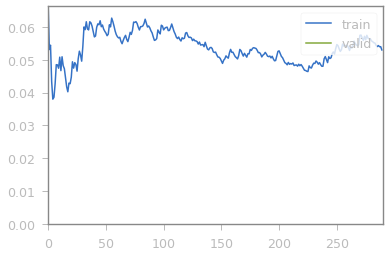

+++++ Training serie: inverse pyramid 11 ++++++++


Max frequency is 63
Min frequency is 46
Min probability = 0.6571428571428571
Dropped 77 top losses
************Round:  11
************data per serie:******************
************length of data per serie:******************
5727


epoch,train_loss,valid_loss,accuracy,time
0,0.054252,0.018920,0.892576,01:35


Better model found at epoch 0 with accuracy value: 0.8925763964653015.


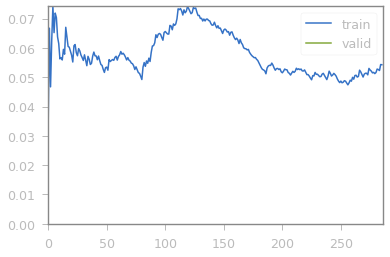

+++++ Training serie: inverse pyramid 12 ++++++++


Max frequency is 63
Min frequency is 46
Min probability = 0.6571428571428571
Dropped 74 top losses
************Round:  12
************data per serie:******************
************length of data per serie:******************
5653


epoch,train_loss,valid_loss,accuracy,time
0,0.065724,0.025036,0.883186,01:34


Better model found at epoch 0 with accuracy value: 0.883185863494873.


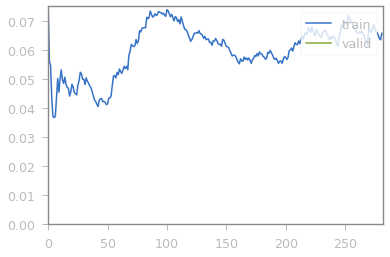

************Round:  12
TTA Accuracy:0.7410740852355957
cycle 2 Error Rate is [{0: (1.364931753412324, 26.912689208984375), 3: (5.18974051297435, 25.232523679733276), 6: (8.714564271786408, 24.932491779327393), 9: (12.044397780110994, 23.882389068603516), 12: (15.359232038398085, 25.38253664970398), 15: (1.3349332533373337, 26.37263536453247), 18: (5.0397480125993654, 24.722474813461304), 21: (8.339583020848963, 24.272429943084717), 24: (11.684415779211044, 25.17251968383789), 27: (14.969251537423133, 25.65256357192993), 30: (1.3049347532623323, 25.562554597854614), 33: (4.979751012449373, 25.50255060195923), 36: (8.654567271636415, 26.10260844230652), 39: (11.984400779961002, 26.13261342048645), 42: (15.2092395380231, 25.89259147644043)}]
+++++ Training serie: inverse pyramid 13 ++++++++


Max frequency is 63
Min frequency is 45
Min probability = 0.6428571428571429
Dropped 64 top losses
************Round:  13
************data per serie:******************
************length of data per serie:******************
5589


epoch,train_loss,valid_loss,accuracy,time
0,0.094238,0.028442,0.906893,01:31


Better model found at epoch 0 with accuracy value: 0.9068934917449951.


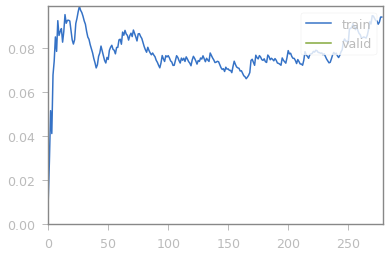

+++++ Training serie: inverse pyramid 14 ++++++++


Max frequency is 63
Min frequency is 43
Min probability = 0.6142857142857143
Dropped 65 top losses
************Round:  14
************data per serie:******************
************length of data per serie:******************
5524


epoch,train_loss,valid_loss,accuracy,time
0,0.650918,0.723374,0.897645,01:31


Better model found at epoch 0 with accuracy value: 0.8976449370384216.


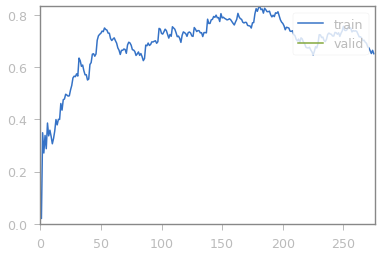

In [29]:
delta_max = 0.50
accs = []
deltas = []
err = {}
for c in range(cleaning_cycles):
    for n in range(n_training_series):
        
        delta =  delta_max * math.sin( math.pi * float(n+1)/(n_training_series) )
#         print(f'delta = {delta}')
        loss_func = losses.DampedCELossFlat(num_classes=196,delta=delta, reduction='mean')
        k_samples = 100
        print(f'+++++ Training serie: inverse pyramid {n} ++++++++')
        epochs_per_serie = min_epochs + n * delta_epochs_per_serie
        lr = min_lr * kappa_lr * (n_training_series - n)
#         print("dynamic LR", dynamic_lr)
        data_per_serie[n+1] = data_definition(data_per_serie[n],imgs,batch_tfms,model,best_pth,k_samples=k_samples, 
                                              min_prob = min_prob, max_prob=max_prob, largest = largest)
        print("************Round: ",n)
        print("************data per serie:******************")
    #     data_per_serie[n+1]
        print("************length of data per serie:******************")
        print(len(data_per_serie[n+1]))
        
        databunch = ( ImageDataLoaders.from_df(data_per_serie[n+1], valid_pct = 0.2,bs=bs,label_col=1,
                                        shuffle_train=True,
                                        item_tfms=Resize(imgs),
                                        batch_tfms = batch_tfms))

    #     learn = ( learner_type(databunch, model,metrics=[accuracy,top_5],loss_func=loss,cbs=[ShowGraphCallback(),history]).to_fp16())
        learn =(learner_type(databunch, model,metrics=[accuracy],loss_func=loss_func,
                            cbs=[ShowGraphCallback(),checkpoints]).to_fp16())
#         learn.split( lambda m: (model._conv_head) )
        learn.unfreeze() 
        learn.load(best_pth)
#         learn.fit_one_cycle(epochs_per_serie, max_lr=slice(min_lr,lr),cbs=[SaveModelCallback(learn,metrics=[accuracy], name=best_pth)])
        learn.fit_one_cycle(epochs_per_serie, lr_max=slice(1e-6, 5e-5))
        if n%3== 0:
            log_preds, y = learn.tta(dl=data_test)
            print("************Round: ",n)
            tta_acc = accuracy(log_preds, y)
            print(f'TTA Accuracy:{tta_acc}')
            accs.append(tta_acc)
            deltas.append(delta)
            err[c*n_training_series + n] = ( 100.0 *float(1.0 - len(data_per_serie[n+1])/len(data_per_serie[0])) ,  100.0 * (1.0 - float(tta_acc)))
            print(f'cycle {c} Error Rate is [{err}]')
#             inter_test = ClassificationInterpretation.from_learner(learn, dl =data_test)
#             inter_test.plot_confusion_matrix(figsize = (10,10))
            PATH='models/'+damp_2_features+'_'+str(c)+"_"+str(n)+".p"
            torch.save(model.state_dict(), PATH)
            csv = data_per_serie[n+1].to_csv('CSVz/'+damp_2_csvs+'_'+str(c)+"_"+str(n)+".csv", index = False)     
    

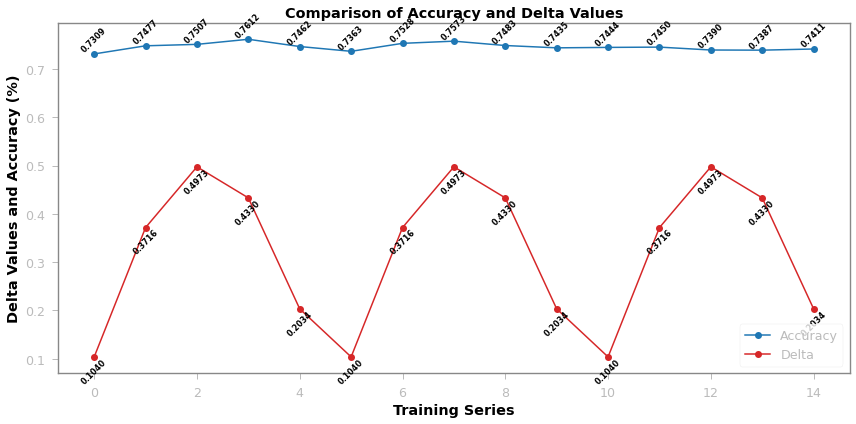

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(accs, label='Accuracy', color='tab:blue', marker='o')
plt.plot(deltas, label='Delta', color='tab:red', marker='o')

# Annotating each point with its value in black and with bold labels
for i, (acc, delta) in enumerate(zip(accs, deltas)):
    plt.text(i, acc, f"{acc:.4f}", ha='center', va='bottom', fontsize=8, rotation=45, color='black', fontweight='bold')
    plt.text(i, delta, f"{delta:.4f}", ha='center', va='top', fontsize=8, rotation=45, color='black', fontweight='bold')

plt.title('Comparison of Accuracy and Delta Values', fontweight='bold', color = 'Black')
plt.xlabel('Training Series', fontweight='bold', color = 'black')
plt.ylabel('Delta Values and Accuracy (%)', fontweight='bold', color = 'Black')
plt.legend()
plt.grid(False)
plt.tight_layout()  # Adjust layout to prevent clipping of annotations
plt.show()
